# 필요 모듈 미치 데이터 로드

In [1]:
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [2]:
# from konlpy.tag import Mecab

In [3]:
# pip install mecab-python


In [4]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 18.4 MB/s eta 0:00:00


In [5]:
# Mecab 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

# mecab-python의 버전 오류로 인해 아래 패키지를 설치하면 코랩에서 Mecab을 사용가능
!pip install mecab-python3


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [662 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,056 kB]
Get:13 http://archive.ubun

In [6]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from collections import Counter

from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [7]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt",
                           filename="ratings_total.txt")

# 데이터에는 열 제목이 없음.
# 컬럼명 설정
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

# 전체 리뷰 개수 출력
print('전체 리뷰 개수 :', len(total_data))

# 샘플 확인
total_data[:3]


전체 리뷰 개수 : 200000


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...


In [8]:
total_data[['ratings']].value_counts()

ratings
5          81177
2          63989
1          36048
4          18786
dtype: int64

# eda와 전처리

In [9]:
# 데이터에 label(y값) 이 없음
# 평점 4, 5인 리뷰를 1
# 평점 1, 2인 리뷰를 0 으로 label 컬럼 생성
np.select([total_data.ratings > 3], [1], default=0)
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

# 결과 확인
total_data[:3]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1


In [10]:
# 컬럼별 중복을 제외한 샘플 수
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()


(4, 199908, 2)

In [11]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플 수 :', len(total_data))

총 샘플 수 : 199908


In [12]:
train_data, test_data = train_test_split(total_data,
                                         test_size  = 0.25,
                                         random_state= 42)
print('훈련용   리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용   리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


In [13]:
# 정규표현식 사용
# 한글 제외하고 모두 제거 후 결측치 확인

# 학습 데이터
train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

train_data['reviews'].replace('', np.nan, inplace=True)
train_data.isna().sum()

<ipython-input-13-3271f0790205>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-13-3271f0790205>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64

In [14]:
# 테스트 데이터
test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

test_data['reviews'].replace('', np.nan, inplace=True)
test_data.isna().sum()


<ipython-input-14-90ab94d75d9b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-14-90ab94d75d9b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64

In [15]:
print('전처리 후 학습   데이터 샘플 :', len(train_data))
print('전처리 후 테스트 데이터 샘플 :', len(test_data))

전처리 후 학습   데이터 샘플 : 149931
전처리 후 테스트 데이터 샘플 : 49977


In [16]:
mecab = Mecab()
print(mecab.morphs('열심히 leo-contigo님 깃허브 복사중,, 대애애애박!!'))

['열심히', 'leo', '-', 'contigo', '님', '깃', '허브', '복사', '중', ',', ',', '대', '애', '애', '애박', '!', '!']


In [17]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에',
             '하', '고', '을', '를', '인', '듯', '과', '와', '네',
             '들', '듯', '지', '임', '게']


In [18]:
train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [19]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
# 단어들을 리스트로 저장.
# 1 : 긍정 / 0 : 부정
np.hstack(train_data[train_data.label == 0]['tokenized'].values)
np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

# counter() 를 사용하여 각 단어에 대한 빈도수 계산.
Counter(negative_words)
negative_word_count = Counter(negative_words)
positive_word_count = Counter(positive_words)
print('부정적인 단어 상위 3개 :', negative_word_count.most_common(3))
print('긍정적인 단어 상위 3개 :', positive_word_count.most_common(3))


부정적인 단어 상위 3개 : [('네요', 31802), ('는데', 20197), ('안', 19719)]
긍정적인 단어 상위 3개 : [('좋', 39422), ('아요', 21186), ('네요', 19894)]


긍정 리뷰의 평균 길이 : 13.57963286363697
부정 리뷰의 평균 길이 : 17.03148775995088


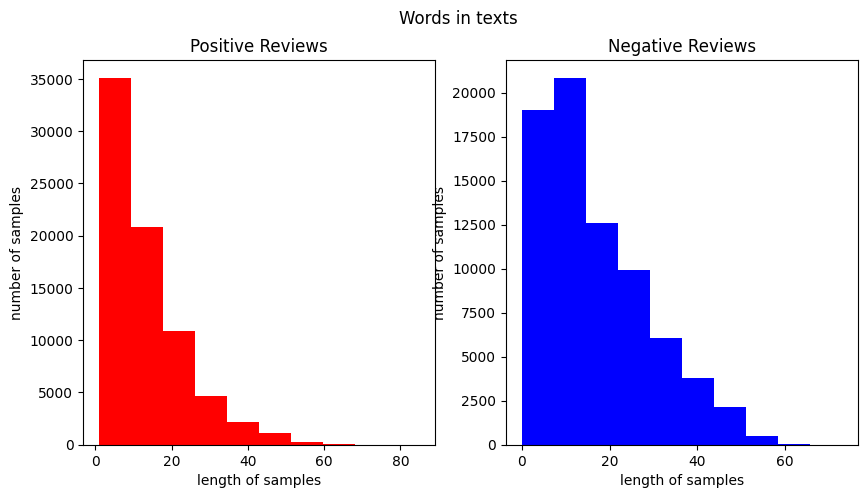

In [21]:
# 분포를 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [22]:
train_data['tokenized'].values

array([list(['사이즈', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요']),
       list(['ㅂ', '불', '만족', '빗이', '아픔', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요']),
       list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '많', '걸', '어쩌', '나요', '반품', '싶']),
       ..., list(['장', '주문', '안', '됩니다', '장', '가능', '해요']),
       list(['하림', '치킨', '여기', '서', '구입', '니', '엄청', '저렴', '네요', '배송', '쾅', '꽝', '얼', '어서', '도착', '아주', '만족', '합니다', 'ㅋㅋ']),
       list(['조금', '약해', '보이', '는데', '저렴', '잘', '삿', '어요'])], dtype=object)

In [23]:

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values


정수 인코딩
학습 데이터와 테스트 데이터에 정수 인코딩을 수행.
단어 집합 만들기(vocaburary)

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
# 단어 집합이 생성되면서 단어에 고유한 정수가 부여됨.
tokenizer.word_index

# 횟수가 1회인 단어들은 자연어 처리에서 배제.

{'네요': 1,
 '좋': 2,
 '어요': 3,
 '는데': 4,
 '아요': 5,
 '잘': 6,
 '있': 7,
 '구매': 8,
 '안': 9,
 '배송': 10,
 '습니다': 11,
 '했': 12,
 '너무': 13,
 '같': 14,
 '거': 15,
 '어': 16,
 '먹': 17,
 '합니다': 18,
 '되': 19,
 '재': 20,
 '요': 21,
 '기': 22,
 '쓰': 23,
 '않': 24,
 '없': 25,
 '것': 26,
 '아': 27,
 '로': 28,
 '해서': 29,
 '사용': 30,
 '았': 31,
 '나': 32,
 '으로': 33,
 '만': 34,
 '보다': 35,
 '었': 36,
 '겠': 37,
 '주': 38,
 '지만': 39,
 '아서': 40,
 '그냥': 41,
 '해': 42,
 '보': 43,
 '제품': 44,
 '서': 45,
 '면': 46,
 '어서': 47,
 '가격': 48,
 '해요': 49,
 '좀': 50,
 '만족': 51,
 '생각': 52,
 '주문': 53,
 '입니다': 54,
 '라': 55,
 '더': 56,
 '받': 57,
 '니': 58,
 '할': 59,
 '맛': 60,
 '많이': 61,
 '개': 62,
 '사': 63,
 '때': 64,
 '시': 65,
 '사이즈': 66,
 '에서': 67,
 '빠르': 68,
 '왔': 69,
 '샀': 70,
 '번': 71,
 '작': 72,
 '음': 73,
 '맛있': 74,
 'ㅠㅠ': 75,
 '포장': 76,
 '별로': 77,
 '수': 78,
 '두': 79,
 '입': 80,
 '맞': 81,
 '던': 82,
 '다른': 83,
 '저렴': 84,
 '괜찮': 85,
 '세요': 86,
 '넘': 87,
 '못': 88,
 '상품': 89,
 '정말': 90,
 '하나': 91,
 '데': 92,
 '아니': 93,
 '에요': 94,
 'ㅠ': 95,
 '냄새': 96,
 '부

In [26]:

# 단어들이 데이터에서 차지하는 비중 확인

threshold = 2

# 단어의 수
len(tokenizer.word_index)
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold = 2 보다 작은 단어의 수 확인.
rare_cnt = 0

# 학습 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

In [27]:
# 단어와 빈도수의 쌍(pair)을 key 와 value로

for key, value in tokenizer.word_counts.items() :
  # 학습 데이터의 전체 단어 빈도수 총합
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 2보다 작으면
  if (value < threshold) :
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기                :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수       : %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율              :", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기                : 40126
등장 빈도가 1번 이하인 희귀 단어의 수       : 18274
단어 집합에서 희귀 단어의 비율              : 45.54154413597169
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 0.7963866689560858


In [28]:
# 전체 단어 개수 중 빈도수 2 이하인 단어 개수 제거
# 단어의 수 - 등장 빈도수 2 이하
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

total_cnt - rare_cnt +2
vocab_size = total_cnt - rare_cnt +2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21854


토크나이저 인자로 넘겨주고
텍스트 시퀀스 → 정수 시퀀스 로 변환
정수 인코딩과정에서 vocab_size 보다 큰 숫자가 부여된 단어를 OOV로 변환

In [29]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
print(X_train[:3])
print(X_test[:3])

[[67, 2060, 300, 14295, 263, 73, 6, 237, 168, 136, 801, 2940, 626, 2, 76, 62, 207, 40, 1344, 155, 3, 6], [482, 400, 52, 8525, 2592, 2450, 338, 2941, 251, 2351, 39, 473, 2], [45, 24, 832, 104, 35, 2366, 160, 7, 10, 8058, 4, 1319, 30, 138, 323, 44, 59, 160, 138, 7, 1916, 2, 113, 163, 1385, 307, 119, 135]]
[[14, 704, 767, 115, 186, 252, 12], [338, 3907, 62, 3819, 1624], [11, 69, 2, 49, 164, 3, 27, 15, 6, 514, 289, 17, 92, 110, 584, 59, 7, 2]]


패딩
서로 다른 길이의 문장을 동일하게 맞춰주는 작업.

In [31]:

# 전체 데이터에서 긴 리뷰와 짧은 리뷰 확인.
max(len(review) for review in X_train)
round(sum(map(len, X_train)) / len(X_train), 2)

print('리뷰 최대 길이 :', max(len(review) for review in X_train))
print('리뷰 평균 길이 :', round(sum(map(len, X_train)) / len(X_train), 2))

리뷰 최대 길이 : 85
리뷰 평균 길이 : 15.3


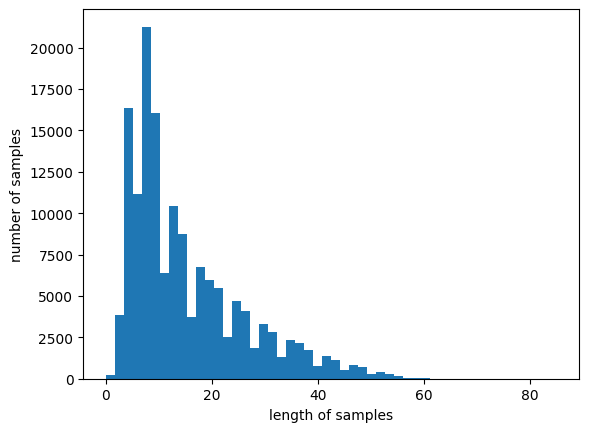

In [32]:
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();


In [33]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

# 길이가 80으로 패딩할 경우 몇개의 샘플을 보전할 수 있는지?
max_len = 80
below_threshold_len(max_len, X_train)

# 리뷰의 99% 80이하의 길이를 가짐.


전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [34]:

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


# 모델링

GRU 리뷰 감성 분류하기
하이퍼 파라미터 임베딩 백터의 차원 : 100

은닉 상태의 크기 : 128

다 대 일 구조의 LSTM 사용

이진 분류

출력층 : 로지스틱 회귀를 사용 = 시그모이드(sigmoid) 함수사용
손실함수 = 크로스 엔트로피(binary_crossentropy) 함수 사용
배치사이즈 : 64

학습 15

EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

검증데이터 손실(val_loss) 증가하면 과적합
검증데이터 손실(val_loss) 4회 증가하면 정해진 epoch가 도달하지 않아도 학습을 조기 종료(EarlyStooping).
ModelCheckpoint : 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장.

validation_split=0.2 : 훈련데이터의 20%를 검증데이터로 분리해서 사용해서 학습 잘 되는지 확인.
검증 데이터는 기계가 훈련 데이터에 과적합되고 있는지 않은지 확인하기 위한 용로도 사용.

In [35]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2185400   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2273849 (8.67 MB)
Trainable params: 2273849 (8.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=15, callbacks=[es, mc],
                    batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2910 - acc: 0.8877
Epoch 1: val_acc improved from -inf to 0.91256, saving model to best_model.h5
2000/2000 [==============================] - 363s 180ms/step - loss: 0.2910 - acc: 0.8877 - val_loss: 0.2417 - val_acc: 0.9126
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - ETA: 0s - loss: 0.2277 - acc: 0.9183
Epoch 2: val_acc improved from 0.91256 to 0.91866, saving model to best_model.h5
2000/2000 [==============================] - 351s 176ms/step - loss: 0.2277 - acc: 0.9183 - val_loss: 0.2241 - val_acc: 0.9187
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2071 - acc: 0.9260
Epoch 3: val_acc improved from 0.91866 to 0.92363, saving model to best_model.h5
2000/2000 [==============================] - 353s 176ms/step - loss: 0.2071 - acc: 0.9260 - val_loss: 0.2140 - val_acc: 0.9236
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1923 - acc: 0.9325
Epoch 4: val_acc did not improve from 0.92363
2000/2000 [==============================] - 353s 176ms/step - loss: 0.1923 - acc: 0.9325 - val_loss: 0.2176 - val_acc: 0.9226
Epoch 5/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1808 - acc: 0.9375
Epoch 5: val_acc did not improve from 0.92363
2000

In [37]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 35s 22ms/step - loss: 0.2190 - acc: 0.9211

 테스트 정확도: 0.9211


리뷰 예측하기

In [38]:

# 임의 문장에 대한 예측
# 학습 하기 전 전처리 동일하게 처리.
# 전처리의 순서 : 정규 표현식을 통한 한국어 외 문자 제거→토큰화→불용어 제거→정수 인코딩→패딩 순

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    # print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    return 1
  else:
    # print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
    return 0

In [39]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 414ms/step


1

In [40]:
sentiment_predict('배송만 빨라요 제품은 .....')

1/1 [==============================] - 0s 24ms/step


0

In [41]:
sentiment_predict('이뻐요!! 하지만 배송이 좀 느려서 그건 아쉽네요 ㅜ')

1/1 [==============================] - 0s 25ms/step


1

In [42]:
sentiment_predict('너무 이쁘기는 한데 사이즈가 표시된 거랑은 좀 달라서 아쉽네요ㅜ')

1/1 [==============================] - 0s 35ms/step


0

In [43]:
sentiment_predict('화면이랑 너무 달라요. 화면에는 이뻐 보였는데 실제로 보니까 실밥도 나오고 그러네요. ')

1/1 [==============================] - 0s 24ms/step


0

# 실제 리뷰 데이터 적용하기

In [44]:
df = pd.read_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/csv 폴더 모음/크롤링 데이터 240119/review_240119.csv')
df.head()

,Unnamed: 0.1,product_names,product_ids,user_names,user_ratings,user_reviews,Unnamed: 0
0,0,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,킴오복,80,깔끔하고 입기 편안해요 손이 자주가는 편한 느낌,NaN
1,1,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,오버한 사이즈고 입으면 더 예쁩니다. 부드럽고 적당한 두께감이라 겨울에 아주 잘입을...,NaN
2,2,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,퓨블릭a.,100,많이 길고 오버할 줄 알았는데 그렇지 않아서 좋구여 예쁩니다. 다른 색깔도 살듯..,NaN
3,3,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,YANGMAL2,80,굿굿 생각한거보다 이쁘네영 자주 손이가네요 추천합니다,NaN
4,4,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,.ㅡㅡㅡㅡㅡ.,100,살짝 얇은 원단이 아쉽지만 전체적으로 가격을 뛰어 넘는 품질입니다.,NaN


In [45]:
id = list(df.product_ids.unique())

In [46]:
review_score = df[df.product_ids == id[0]]
review_score.head()

,Unnamed: 0.1,product_names,product_ids,user_names,user_ratings,user_reviews,Unnamed: 0
0,0,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,킴오복,80,깔끔하고 입기 편안해요 손이 자주가는 편한 느낌,NaN
1,1,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,오버한 사이즈고 입으면 더 예쁩니다. 부드럽고 적당한 두께감이라 겨울에 아주 잘입을...,NaN
2,2,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,퓨블릭a.,100,많이 길고 오버할 줄 알았는데 그렇지 않아서 좋구여 예쁩니다. 다른 색깔도 살듯..,NaN
3,3,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,YANGMAL2,80,굿굿 생각한거보다 이쁘네영 자주 손이가네요 추천합니다,NaN
4,4,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,.ㅡㅡㅡㅡㅡ.,100,살짝 얇은 원단이 아쉽지만 전체적으로 가격을 뛰어 넘는 품질입니다.,NaN


In [47]:
review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
# review_score

1/1 [==============================] - 0s 25ms/step


<ipython-input-47-a9f6a9872fef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


In [48]:
score = pd.DataFrame(columns = ['product_ids', 'score'])

In [49]:
review_score

,Unnamed: 0.1,product_names,product_ids,user_names,user_ratings,user_reviews,Unnamed: 0,score
0,0,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,킴오복,80,깔끔하고 입기 편안해요 손이 자주가는 편한 느낌,NaN,1
1,1,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,오버한 사이즈고 입으면 더 예쁩니다. 부드럽고 적당한 두께감이라 겨울에 아주 잘입을...,NaN,1
2,2,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,퓨블릭a.,100,많이 길고 오버할 줄 알았는데 그렇지 않아서 좋구여 예쁩니다. 다른 색깔도 살듯..,NaN,1
3,3,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,YANGMAL2,80,굿굿 생각한거보다 이쁘네영 자주 손이가네요 추천합니다,NaN,1
4,4,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,.ㅡㅡㅡㅡㅡ.,100,살짝 얇은 원단이 아쉽지만 전체적으로 가격을 뛰어 넘는 품질입니다.,NaN,1
5,5,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,zzzaaaqqq,100,옷 이쁘고 오랫동안 입을 것 같아요 좋아요 잘 샀어요,NaN,1
6,6,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,web,100,"다른 색상을 워낙 1년동안 잘 입어서, 추가 구매합니다~",NaN,1
7,7,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,멤버_b01d33a2830f,100,그림이 힙하고 핏도 적당해서 어디에나 입기 좋습니다,NaN,1
8,8,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,9r0ver,20,흠..핏도 애매 재질도 애매 잘 안 입게 되는 제품이네요..,NaN,0
9,9,오버사이즈 16골 에센셜 코듀로이 셔츠 블랙,22FWGS28BK,jsm0824,100,도톰해서 요즘 입기 딱 좋고 단추풀고 아우터러 입어도 되고 목끝까지 단추 잠궈서 그...,NaN,1


In [50]:
a = review_score.groupby('product_ids').mean('score').reset_index()[['product_ids', 'score']]

In [51]:
a

,product_ids,score
0,22FWGS28BK,0.857143


In [52]:
score = pd.concat([score, a], ignore_index=True)
score

,product_ids,score
0,22FWGS28BK,0.857143


In [53]:
id = list(df.product_ids.unique())
score = pd.DataFrame(columns = ['product_ids', 'score'])

In [59]:
id = list(df.product_ids.unique())
score = pd.DataFrame(columns = ['product_ids', 'score'])


from tqdm.notebook import tqdm
for i in tqdm(id):
  review_score = df[df.product_ids == i]
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
  a = review_score.groupby('product_ids').mean('score').reset_index()[['product_ids', 'score']]
  score = pd.concat([score, a], ignore_index=True)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 55ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 59ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 52ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 56ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 53ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 52ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 23ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 52ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 52ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 53ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 65ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 57ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 61ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-59-58925ba1ea62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


In [63]:
score.shape

(1000, 2)

In [64]:
a = pd.read_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/감성분석0-2640.csv')
b = pd.read_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/감성분석0-3140.csv')
c = pd.read_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/감성분석3141-3640.csv')
d = pd.read_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/감성분석3641-4140.csv')
e = pd.read_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/감성분석3641-4641.csv')


In [66]:
score.to_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/감성분석3641-4641.csv')

In [73]:
x = pd.concat([a, b, c, d, e, score]).drop_duplicates()

In [74]:
x.columns

Index(['Unnamed: 0', 'product_ids', 'score'], dtype='object')

In [95]:
id2 = list(set(id) - set((x['product_ids'].unique())))
len(id2)

3141

In [102]:
for i in tqdm(id2[:500]):
  review_score = df[df.product_ids == i]
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
  a = review_score.groupby('product_ids').mean('score').reset_index()[['product_ids', 'score']]
  score = pd.concat([score, a], ignore_index=True)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 80ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 53ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 53ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 56ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 61ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 52ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 56ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 53ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 73ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 58ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 43ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 52ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 71ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 56ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 57ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 63ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 66ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 65ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 78ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 68ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 64ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 62ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 53ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 55ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 52ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 40ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 53ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 67ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 24ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 57ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 44ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 55ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 41ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 48ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 50ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 55ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 52ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 30ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 25ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 45ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 51ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 46ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 34ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 38ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 37ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 62ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 47ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 75ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 54ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 33ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 36ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 35ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 73ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 32ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 31ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 42ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - ETA: 0s

<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 27ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)
<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 39ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 28ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 29ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 49ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


1/1 [==============================] - 0s 26ms/step


<ipython-input-102-1d089a4a3146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_score['score'] = review_score['user_reviews'].apply(sentiment_predict)


In [103]:
score.shape

(2500, 2)

In [101]:
# x = pd.concat([a, b, c, d, e, score]).drop_duplicates()
# x.to_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/4000개.csv')

In [114]:
x = pd.read_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/4000개.csv')
x.drop_duplicates().shape

(4000, 4)

In [108]:
x1 = pd.concat([x, score]).drop_duplicates()

In [115]:
len(x.product_ids.unique())

3000

In [112]:
score.to_csv('/content/drive/MyDrive/제로베이스/제로베이스 머신러닝 프로젝트/k김주희/4000+.csv')

In [100]:
id2 = list(set(id) - set((x['product_ids'].unique())))
len(id2)

3141

In [119]:
x1 = x1.reset_index(drop=True).drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
x1.drop_duplicates()

,product_ids,score
0,Pack_13,0.809524
1,5002753232,0.902439
2,2020F60,0.928571
3,ABC8DP02GR,0.900000
4,5001751634,0.756098
...,...,...
6495,DEVITS0032WHITE,0.631579
6496,PPTOAWCR32UC6,0.909091
6497,SL212,0.736842
6498,HALF-NECK LONG SLEEVE T-SHIRTS (BLACK),0.921053
